## Import Statement

In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import functions as sf
from matplotlib import pyplot as plt
from pyspark.sql.functions import col, avg
import pandas as pd
import pyspark
from datetime import datetime, timedelta, date
from pyspark.sql.functions import broadcast
from pyspark.sql.types import DateType
from pyspark.sql.functions import col, avg, date_format,month,hour,lag, date_sub,lit

In [2]:
log4jLogger = sc._jvm.org.apache.log4j
LOGGER = log4jLogger.LogManager.getLogger(__name__)
LOGGER.error("pyspark script logger initialized")

In [3]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

In [4]:
base_path = "/home/test5/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)

In [5]:
#sqlcontext
household_info = sqlcontext.read.csv(base_path+"informations_households.csv",header=True,inferSchema=True)
#household_mini = sc.parallelize(household_info.take(1)).toDF()
household_mini = household_info

In [6]:
household_mini.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- file: string (nullable = true)



In [7]:
column_list = []
for i in range(48):
    column_list.append("hh_"+str(i))
column_list
new_column_list = []
for i in range(1,49):
    if i<20:
        new_column_list.append("0"+str(i*0.5))
    else:
        new_column_list.append(str(i*0.5))

In [8]:
flag = 0
df_full = []
df_file = household_mini.select("file").distinct()
# exprs = {x: "avg" for x in new_column_list}
exprs1 = [avg(x) for x in column_list[0:40]]
exprs2 = [avg(x) for x in column_list[40:48]]        #due to the fact large number of column giving error so divide
count = 0
for row in df_file.rdd.collect():
    file = row.file
    print(file,count)
    count += 1
    file_path = base_path + "hhblock_dataset/"+ file+".csv"
    half_hourly_consumption_data = sqlcontext.read.csv(file_path,header=True,inferSchema=True).cache()
    half_hourly_consumption_data.dropna(how='any')
    #half_hourly_consumption_data2 = half_hourly_consumption_data.groupBy('LCLid').agg(*exprs2)
    #half_hourly_consumption_data = half_hourly_consumption_data.groupBy('LCLid').agg(*exprs1)
    #half_hourly_consumption_data = half_hourly_consumption_data.join(half_hourly_consumption_data2,["LCLid"])
    #half_hourly_consumption_data.dropna(how='any')
    #half_hourly_consumption_data.printSchema()
    if flag == 0:
        df_full = sqlcontext.createDataFrame([],half_hourly_consumption_data.schema)
        flag = 1
    df_full = df_full.union(half_hourly_consumption_data)
    df_full = df_full.cache()

block_64 0
block_91 1
block_39 2
block_43 3
block_77 4
block_19 5
block_35 6
block_53 7
block_26 8
block_20 9
block_52 10
block_12 11
block_21 12
block_36 13
block_89 14
block_84 15
block_49 16
block_93 17
block_99 18
block_18 19
block_44 20
block_8 21
block_71 22
block_104 23
block_4 24
block_29 25
block_38 26
block_47 27
block_48 28
block_42 29
block_85 30
block_27 31
block_108 32
block_76 33
block_1 34
block_3 35
block_56 36
block_94 37
block_72 38
block_75 39
block_78 40
block_62 41
block_101 42
block_46 43
block_110 44
block_32 45
block_51 46
block_45 47
block_59 48
block_40 49
block_15 50
block_95 51
block_96 52
block_5 53
block_68 54
block_28 55
block_97 56
block_82 57
block_69 58
block_70 59
block_61 60
block_24 61
block_33 62
block_23 63
block_31 64
block_67 65
block_0 66
block_14 67
block_41 68
block_100 69
block_22 70
block_109 71
block_83 72
block_30 73
block_88 74
block_98 75
block_106 76
block_37 77
block_10 78
block_80 79
block_103 80
block_55 81
block_73 82
block_111 83

In [9]:
#avg_house_data.take(1)
df_full = df_full.repartition(480,"LCLid")
df_full.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- day: timestamp (nullable = true)
 |-- hh_0: double (nullable = true)
 |-- hh_1: double (nullable = true)
 |-- hh_2: double (nullable = true)
 |-- hh_3: double (nullable = true)
 |-- hh_4: double (nullable = true)
 |-- hh_5: double (nullable = true)
 |-- hh_6: double (nullable = true)
 |-- hh_7: double (nullable = true)
 |-- hh_8: double (nullable = true)
 |-- hh_9: double (nullable = true)
 |-- hh_10: double (nullable = true)
 |-- hh_11: double (nullable = true)
 |-- hh_12: double (nullable = true)
 |-- hh_13: double (nullable = true)
 |-- hh_14: double (nullable = true)
 |-- hh_15: double (nullable = true)
 |-- hh_16: double (nullable = true)
 |-- hh_17: double (nullable = true)
 |-- hh_18: double (nullable = true)
 |-- hh_19: double (nullable = true)
 |-- hh_20: double (nullable = true)
 |-- hh_21: double (nullable = true)
 |-- hh_22: double (nullable = true)
 |-- hh_23: double (nullable = true)
 |-- hh_24: double (nullable = true)
 |-- 

## filtering data as per requirement
Total user in 2013  5528

Total user in 2013 with full evidence  3961


In [10]:
df_full = df_full.withColumn("day",df_full["day"].cast(DateType()))
df_full.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- day: date (nullable = true)
 |-- hh_0: double (nullable = true)
 |-- hh_1: double (nullable = true)
 |-- hh_2: double (nullable = true)
 |-- hh_3: double (nullable = true)
 |-- hh_4: double (nullable = true)
 |-- hh_5: double (nullable = true)
 |-- hh_6: double (nullable = true)
 |-- hh_7: double (nullable = true)
 |-- hh_8: double (nullable = true)
 |-- hh_9: double (nullable = true)
 |-- hh_10: double (nullable = true)
 |-- hh_11: double (nullable = true)
 |-- hh_12: double (nullable = true)
 |-- hh_13: double (nullable = true)
 |-- hh_14: double (nullable = true)
 |-- hh_15: double (nullable = true)
 |-- hh_16: double (nullable = true)
 |-- hh_17: double (nullable = true)
 |-- hh_18: double (nullable = true)
 |-- hh_19: double (nullable = true)
 |-- hh_20: double (nullable = true)
 |-- hh_21: double (nullable = true)
 |-- hh_22: double (nullable = true)
 |-- hh_23: double (nullable = true)
 |-- hh_24: double (nullable = true)
 |-- hh_25

In [11]:
#df_full = df_full.withColum("date",date_format(df_full["date"],"yyyy-MM-dd").cast(Datetype()))
# df_full = df_full.filter((df_full.day >= date(2013,1,1)) & (df_full.day <= date(2013,10,31)))
df_full = df_full.na.drop()
# print ("Total user in 2013 ", df_full.select("LCLid").distinct().count())
# year_df = df_full.groupBy("LCLid").count()
# year_df = year_df.filter(year_df["count"] >= 365 )
# print("Total user in 2013 with full evidence ", year_df.select("LCLid").distinct().count())

In [12]:
LCLid_under_Consideration = sqlcontext.read.csv(base_path+"Feature_File/Cleaned_2013_Features_mth_5.csv",header=True)
LCLid_under_Consideration = LCLid_under_Consideration.select("LCLid").distinct()
df_full = df_full.join(broadcast(LCLid_under_Consideration),["LCLid"])
df_full = df_full.filter((df_full.day >= date(2013,1,1)) & (df_full.day <= date(2013,10,31)))
# LCLid_under_Consideration.count() #3930
# year_df = df_full.groupBy("LCLid").count()
# year_df.take(1)
# year_df = year_df.filter(year_df["count"] >= 365 )

In [13]:
half_hourly_consumption_df = df_full#.join(broadcast(year_df),["LCLid"])
half_hourly_consumption_df.take(1)

[Row(LCLid='MAC005124', day=datetime.date(2013, 1, 1), hh_0=0.28800000000000003, hh_1=0.37799999999999995, hh_2=0.313, hh_3=0.34600000000000003, hh_4=0.267, hh_5=0.253, hh_6=0.218, hh_7=0.212, hh_8=0.23399999999999999, hh_9=0.209, hh_10=0.209, hh_11=0.17600000000000002, hh_12=0.213, hh_13=0.21100000000000002, hh_14=0.258, hh_15=0.24100000000000002, hh_16=0.22899999999999998, hh_17=0.174, hh_18=0.157, hh_19=0.249, hh_20=1.015, hh_21=1.631, hh_22=2.9330001, hh_23=0.579, hh_24=0.375, hh_25=0.638, hh_26=2.154, hh_27=0.465, hh_28=0.617, hh_29=0.41200000000000003, hh_30=0.473, hh_31=1.1210001, hh_32=1.341, hh_33=0.595, hh_34=0.5489999999999999, hh_35=0.349, hh_36=0.414, hh_37=0.373, hh_38=0.345, hh_39=0.358, hh_40=0.313, hh_41=0.431, hh_42=0.462, hh_43=0.419, hh_44=0.37200000000000005, hh_45=0.588, hh_46=0.39299999999999996, hh_47=0.386)]

In [14]:
#flag = 0
#avg_house_data = []
#block_read = set([])
#for row in household_mini.rdd.collect():
#    house_id = row.LCLid
#    file = row.file
#    print(house_id,file)
#    file_path = base_path + "hhblock_dataset/"+ file+".csv"
#    if file not in block_read:
##         print("hi")
#        block_read.add(file)
#        half_hourly_consumption_data = sqlcontext.read.csv(file_path,header=True,inferSchema=True)
#        half_hourly_consumption_data.dropna(how='any')
#        for c,n in zip(column_list,new_column_list):
#            half_hourly_consumption_data=half_hourly_consumption_data.withColumnRenamed(c,n)
#    indiv_house_data = half_hourly_consumption_data.where(col("LCLid") == house_id)
#    indiv_house_data = indiv_house_data.toHandy()
#    if indiv_house_data.rdd.isEmpty():
#        print("Missing Id = {} in file = {}".format(house_id,file))
#        continue
#    indiv_house_data = sqlcontext.createDataFrame(indiv_house_data.stratify(['LCLid']).cols[new_column_list].mean().reset_index())
#     indiv_house_data.printSchema()
#    if flag == 0:
#        avg_house_data = sqlcontext.createDataFrame([],indiv_house_data.schema)
#        flag = 1
#    avg_house_data = avg_house_data.union(indiv_house_data)

In [15]:
half_hourly_consumption_data2 = half_hourly_consumption_df.groupBy('LCLid').agg(*exprs2)
half_hourly_consumption_data = half_hourly_consumption_df.groupBy('LCLid').agg(*exprs1)
avg_house_data = half_hourly_consumption_data.join(half_hourly_consumption_data2,["LCLid"])
avg_house_data=avg_house_data.dropna(how='any')
avg_house_data.printSchema()


root
 |-- LCLid: string (nullable = true)
 |-- avg(hh_0): double (nullable = true)
 |-- avg(hh_1): double (nullable = true)
 |-- avg(hh_2): double (nullable = true)
 |-- avg(hh_3): double (nullable = true)
 |-- avg(hh_4): double (nullable = true)
 |-- avg(hh_5): double (nullable = true)
 |-- avg(hh_6): double (nullable = true)
 |-- avg(hh_7): double (nullable = true)
 |-- avg(hh_8): double (nullable = true)
 |-- avg(hh_9): double (nullable = true)
 |-- avg(hh_10): double (nullable = true)
 |-- avg(hh_11): double (nullable = true)
 |-- avg(hh_12): double (nullable = true)
 |-- avg(hh_13): double (nullable = true)
 |-- avg(hh_14): double (nullable = true)
 |-- avg(hh_15): double (nullable = true)
 |-- avg(hh_16): double (nullable = true)
 |-- avg(hh_17): double (nullable = true)
 |-- avg(hh_18): double (nullable = true)
 |-- avg(hh_19): double (nullable = true)
 |-- avg(hh_20): double (nullable = true)
 |-- avg(hh_21): double (nullable = true)
 |-- avg(hh_22): double (nullable = true)
 |

In [16]:
for c,n in zip(avg_house_data.columns[1:],new_column_list):
    avg_house_data=avg_house_data.withColumnRenamed(c,n)
avg_house_data.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- 00.5: double (nullable = true)
 |-- 01.0: double (nullable = true)
 |-- 01.5: double (nullable = true)
 |-- 02.0: double (nullable = true)
 |-- 02.5: double (nullable = true)
 |-- 03.0: double (nullable = true)
 |-- 03.5: double (nullable = true)
 |-- 04.0: double (nullable = true)
 |-- 04.5: double (nullable = true)
 |-- 05.0: double (nullable = true)
 |-- 05.5: double (nullable = true)
 |-- 06.0: double (nullable = true)
 |-- 06.5: double (nullable = true)
 |-- 07.0: double (nullable = true)
 |-- 07.5: double (nullable = true)
 |-- 08.0: double (nullable = true)
 |-- 08.5: double (nullable = true)
 |-- 09.0: double (nullable = true)
 |-- 09.5: double (nullable = true)
 |-- 10.0: double (nullable = true)
 |-- 10.5: double (nullable = true)
 |-- 11.0: double (nullable = true)
 |-- 11.5: double (nullable = true)
 |-- 12.0: double (nullable = true)
 |-- 12.5: double (nullable = true)
 |-- 13.0: double (nullable = true)
 |-- 13.5: double (nul

In [17]:
avg_house_data = avg_house_data.toPandas()

In [18]:
# pd.options.display.max_columns = None
avg_house_data.shape

(3930, 49)

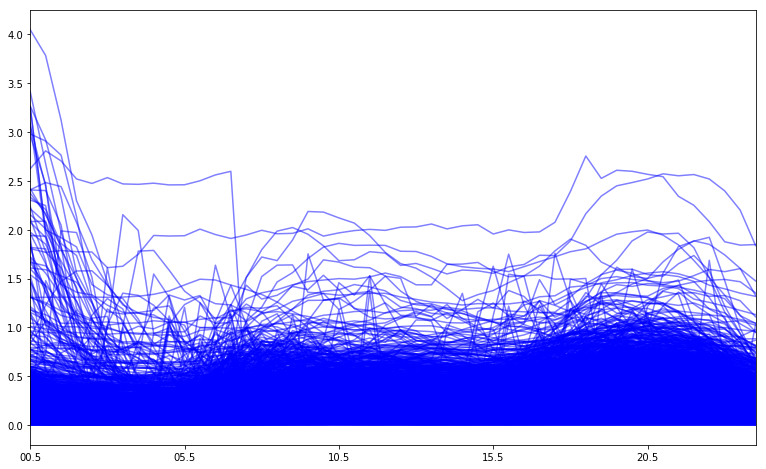

In [19]:
plot = avg_house_data.set_index("LCLid").T.plot(figsize=(13,8), legend=False, color='blue',alpha=0.5)

In [20]:
#avg_house_data1 = sqlcontext.createDataFrame(avg_house_data) 
#avg_house_data1.write.format("csv").save(base_path+"avg.csv")

In [23]:
plot.get_figure().savefig(base_path+"/plot/Avg_LP.png")

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [22]:
avg_house_data.to_csv(base_path+"avg.csv", header=True)